## 3D transformation of rasters using GDAL and proj libraries
- The goal of this notebook is to perform 3D CRS transformations using the command line utility gdalwarp
- Examples of 3DEP DEM, SRTM DEM, and Copernicus DEMs are provided

#### This tutorial stemmed from the [ICESat-2 2023 Hackweek 3D CRS breakout group](https://github.com/ICESAT-2HackWeek/3D_CRS_Transformation_Resources) led by [David Shean](https://github.com/dshean). It uses notes and gotchas on package imports from the notebook shared by [Scott Henderson](https://github.com/scottyhq).

#### Prepared by: [Shashank Bhushan](https://github.com/shashankBice), August 15, 2023

#### TODO: Add example of 3DEP LiDAR 3D transformation

### Setup: Package installs and imports

In [1]:
# From Scott's notebook (https://github.com/ICESAT-2HackWeek/3D_CRS_Transformation_Resources/blob/main/geopandas3D.ipynb)
# NOTE: REQUIRES PROJ>=9.2 and GEOPANDAS>=0.13

!pip install geopandas==0.13 #geopandas is not required for this particular tutorial



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.12.1
    Uninstalling geopandas-0.12.1:
      Successfully uninstalled geopandas-0.12.1


In [41]:
import os
os.environ['USE_PYGEOS'] = '0'
os.environ['PROJ_DEBUG'] = '2' # For showing logs
#os.environ['PROJ_NETWORK'] = 'ON' # Ensure this is 'ON' to get shift grids over the internet
print(os.environ['PROJ_NETWORK']) 

import fiona
import geopandas as gpd
import shapely
import rasterio
import rioxarray
import matplotlib.pyplot as plt
#https://xyzservices.readthedocs.io/en/stable/introduction.html
import xyzservices

ON


In [3]:
gpd.show_versions()


SYSTEM INFO
-----------
python     : 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
executable : /srv/conda/envs/notebook/bin/python
machine    : Linux-5.10.167-147.601.amzn2.x86_64-x86_64-with-glibc2.27

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : 3.11.2
GEOS lib   : None
GDAL       : 3.7.0
GDAL data dir: /srv/conda/envs/notebook/share/gdal
PROJ       : 9.2.1
PROJ data dir: /srv/conda/envs/notebook/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.13.0
numpy      : 1.23.5
pandas     : 1.5.1
pyproj     : 3.6.0
shapely    : 2.0.1
fiona      : 1.9.4
geoalchemy2: None
geopy      : None
matplotlib : 3.6.2
mapclassify: 2.5.0
pygeos     : 0.14
pyogrio    : None
psycopg2   : 2.9.6 (dt dec pq3 ext lo64)
pyarrow    : 12.0.1
rtree      : 1.0.1


In [53]:
### Setup opentopography Global DEM download package

In [8]:
! git clone https://github.com/uw-cryo/opentopo_dem.git

Cloning into 'opentopo_dem'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 35 (delta 17), reused 14 (delta 6), pack-reused 0
Receiving objects: 100% (35/35), 10.78 KiB | 581.00 KiB/s, done.
Resolving deltas: 100% (17/17), done.


### Study Site
We will explore 3D CRS transformation at Grand Mesa, located in Colorado, USA

In [7]:
aoi_fn = 'grandmesa.geojson' #we are going to use Grand Mesa as our example study site
gdf = gpd.read_file('grandmesa.geojson')
terrain_map = xyzservices.providers.Esri.WorldImagery()
gdf.explore(tiles=terrain_map)

### Example 1: SRTM
- The original SRTM product is provided in geographic coordinate system (EPSG:4326), with heights relative to the EGM96 Geoid.
- We will attempt to transform it to UTM 12 N horizontal CRS, with heights relative to the WGS84 ellipsoid
- We will download data on the fly from the opentopography api.

**Note that the opentopography api also provides a SRTM product which already accounts for heights relative to WGS84 ellipsoid,which we will also use as validation**

In [18]:
srtm_gl1_geo_fn = 'grandmesa_SRTM_GL1_epsg4326.tif'
utm_proj = 'EPSG:32612'

In [17]:
! opentopo_dem/download_global_DEM.py -demtype SRTMGL1 -poly_fn $aoi_fn -out_fn $srtm_gl1_geo_fn

[-108.27777581191845, 38.88692329848007, -108.03091154046082, 39.10042883419405]
https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&west=-108.27777581191845&south=38.88692329848007&east=-108.03091154046082&north=39.10042883419405&outputFormat=GTiff&API_Key=demoapikeyot2022
OK!
Script is complete


#### Projection change information
- Information on ESPG code for vertical datums can be found [here](https://www.usna.edu/Users/oceano/pguth/md_help/html/egm96.htm)
- **Input CRS**: EPSG:4326+5773 (Geographic horizontal CRS, with heights relative to EGM96 Geoid)
- **Output CRS**: EPSG:32612+4979 (UTM 12 N horizontal CRS, with heights relative to WGS84 ellipsoid)

In [24]:
# check transformation steps using projinfo command
! projinfo -s EPSG:4326+5773 -t EPSG:32612+4979 -o PROJ --hide-ballpark --spatial-test intersects



pj_open_lib(proj.ini): call fopen(/srv/conda/envs/notebook/share/proj/proj.ini) - succeeded
pj_open_lib(proj.db): call fopen(/srv/conda/envs/notebook/share/proj/proj.db) - succeeded
pj_open_lib(us_nga_egm96_15.tif): call fopen(/home/jovyan/.local/share/proj/us_nga_egm96_15.tif) - succeeded
pj_open_lib(us_nga_egm96_15.tif): call fopen(/home/jovyan/.local/share/proj/us_nga_egm96_15.tif) - succeeded
Candidate operations found: 1
-------------------------------------
Operation No. 1:

pj_open_lib(us_nga_egm96_15.tif): call fopen(/home/jovyan/.local/share/proj/us_nga_egm96_15.tif) - succeeded
unknown id, Inverse of WGS 84 to EGM96 height (1) + UTM zone 12N, 1 m, World.

PROJ string:
+proj=pipeline
  +step +proj=axisswap +order=2,1
  +step +proj=unitconvert +xy_in=deg +xy_out=rad
  +step +proj=vgridshift +grids=us_nga_egm96_15.tif +multiplier=1
  +step +proj=utm +zone=12 +ellps=WGS84


In [22]:
output_srtm_reprojected_fn = 'grandmesa_SRTM_GL1_epsg32612_wgs84ellipsoid.tif'

In [23]:
!gdalwarp -s_srs EPSG:4326+5773 -t_srs EPSG:32612+4979 -tr 30.0 30.0 -r bilinear $srtm_gl1_geo_fn $output_srtm_reprojected_fn

Creating output file that is 737P x 813L.
Processing grandmesa_SRTM_GL1_epsg4326.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image grandmesa_SRTM_GL1_epsg4326.tif.
Copying nodata values from source grandmesa_SRTM_GL1_epsg4326.tif to destination grandmesa_SRTM_GL1_epsg32612_wgs84ellipsoid.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


#### Check if the transformation worked

In [33]:
input_srtm_egm96 = rioxarray.open_rasterio(srtm_gl1_geo_fn)
output_srtm_reprojected = rioxarray.open_rasterio(output_srtm_reprojected_fn)

In [30]:
output_srtm_reprojected.rio.crs

CRS.from_epsg(32612)

In [34]:
input_srtm_egm96.rio.crs

CRS.from_epsg(4326)

In [32]:
output_srtm_reprojected.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes: (12/18)
    crs_wkt:                           PROJCS["WGS 84 / UTM zone 12N",GEOGCS[...
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    inverse_flattening:                298.257223563
    reference_ellipsoid_name:          WGS 84
    longitude_of_prime_meridian:       0.0
    ...                                ...
    longitude_of_central_meridian:     -111.0
    false_easting:                     500000.0
    false_northing:                    0.0
    scale_factor_at_central_meridian:  0.9996
    spatial_ref:                       PROJCS["WGS 84 / UTM zone 12N",GEOGCS[...
    GeoTransform:                      735393.8093058008 30.0 0.0 4332148.484...

In [35]:
input_srtm_egm96.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    horizontal_datum_name:        World Geodetic System 1984
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -108.27791666665718 0.0002777777777778146 0...

Text(0.5, 1.0, 'Median difference after datum change (EGM96Geoid -> WGS84): -17.00 m')

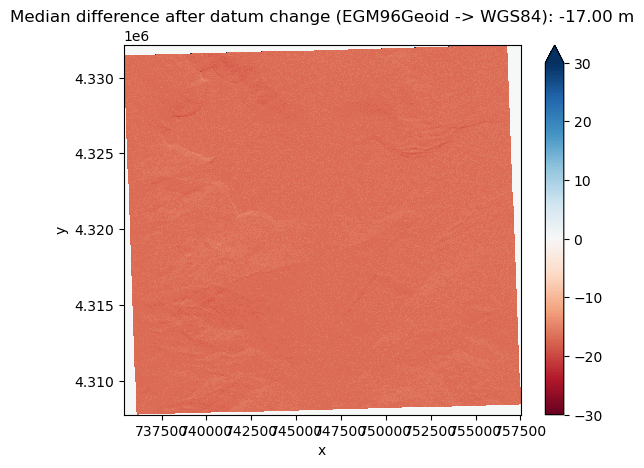

In [60]:
diff = output_srtm_reprojected - input_srtm_egm96.rio.reproject_match(output_srtm_reprojected,resampling=rasterio.enums.Resampling.bilinear)
f,ax = plt.subplots()
diff.plot(vmin=-30, vmax=30, cmap="RdBu",ax=ax)
ax.set_title(f"Median difference after datum change (EGM96Geoid -> WGS84): {diff.median().item():.2f} m")

##### We see that due to transformation of heights from EGM96 Geoid to WGS84 ellipsoid, there is a median height change of -17 m, which makes sense based on Grand Mesa's location. 

#### Sanity Check: Now we will download the SRTM DEM with heights relative the WGS84 ellipsoid from the opentopography api, and compare to our 3D transformed output from above

In [45]:
srtm_gl1_ellipsoidal_fn = 'grandmesa_SRTM_GL1_E.tif'
! opentopo_dem/download_global_DEM.py -demtype SRTMGL1_E -poly_fn $aoi_fn -out_fn $srtm_gl1_ellipsoidal_fn

[-108.27777581191845, 38.88692329848007, -108.03091154046082, 39.10042883419405]
https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1_E&west=-108.27777581191845&south=38.88692329848007&east=-108.03091154046082&north=39.10042883419405&outputFormat=GTiff&API_Key=demoapikeyot2022
OK!
Script is complete


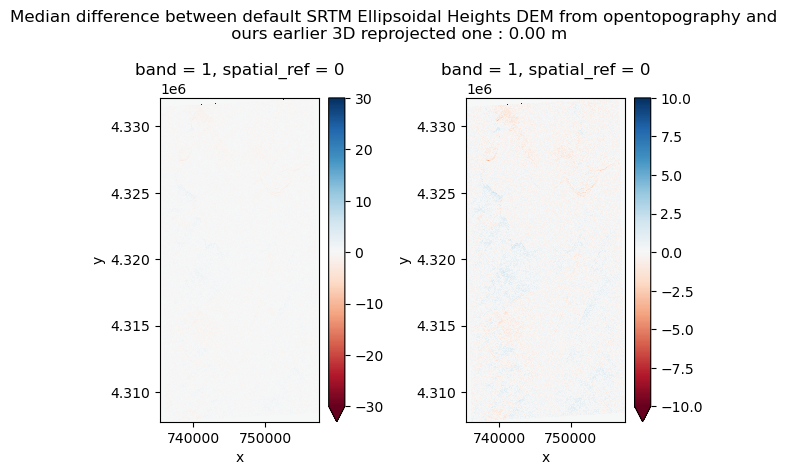

In [52]:
input_srtm_ellipsoidal = rioxarray.open_rasterio(srtm_gl1_ellipsoidal_fn)
diff_srtm_ellipsoidal_output_reproj = output_srtm_reprojected - input_srtm_ellipsoidal.rio.reproject_match(output_srtm_reprojected,resampling=rasterio.enums.Resampling.bilinear)
f,ax = plt.subplots(1,2)
diff_srtm_ellipsoidal_output_reproj.plot(vmin=-30, vmax=30, cmap="RdBu",ax=ax[0])
diff_srtm_ellipsoidal_output_reproj.plot(vmin=-10, vmax=10, cmap="RdBu",ax=ax[1])
f.suptitle(f"Median difference between default SRTM Ellipsoidal Heights DEM from opentopography and \n ours earlier 3D reprojected one : {diff_srtm_ellipsoidal_output_reproj.median().item():.2f} m")
plt.tight_layout()

##### Voila! We see that the difference between OpenTopography default's ellipsoidal heights and our 3D tranformed ellipsoidal height DEM is close to zero, which gives confidence in our conversion. It is not exactly zero though, and we still do observe some residual differences in the plot on the left with colorbars stretched from -10 to 10. This brings out the tricky differences coordinate transformations can bring!

### Example 2: Copernicus Global 30 m DEM

- The original [Copernicus DEM product](https://spacedata.copernicus.eu/documents/20123/121239/GEO1988-CopernicusDEM-SPE-002_ProductHandbook_I4.0.pdf) is provided in geographic coordinate system (EPSG:4326), with heights relative to the EGM2008 Geoid.
- We will attempt to transform it to UTM 12 N horizontal CRS, with heights relative to the WGS84 ellipsoid
- As in example 1, we will download data on the fly from the opentopography api.


In [54]:
copdem_geo_fn = 'grandmesa_COPDEM_epsg4326.tif'
! opentopo_dem/download_global_DEM.py -demtype COP30 -poly_fn $aoi_fn -out_fn $copdem_geo_fn

[-108.27777581191845, 38.88692329848007, -108.03091154046082, 39.10042883419405]
https://portal.opentopography.org/API/globaldem?demtype=COP30&west=-108.27777581191845&south=38.88692329848007&east=-108.03091154046082&north=39.10042883419405&outputFormat=GTiff&API_Key=demoapikeyot2022
OK!
Script is complete


#### Projection change information
- Information on ESPG code for vertical datums can be found [here](https://www.usna.edu/Users/oceano/pguth/md_help/html/egm96.htm)
- **Input CRS**: EPSG:4326+3855 (Geographic horizontal CRS, with heights relative to EGM96 Geoid)
- **Output CRS**: EPSG:32612+4979 (UTM 12 N horizontal CRS, with heights relative to WGS84 ellipsoid)



In [59]:
# check transformation steps using projinfo command
! projinfo -s EPSG:4326+3855 -t EPSG:32612+4979 -o PROJ --hide-ballpark --spatial-test intersects


pj_open_lib(proj.ini): call fopen(/srv/conda/envs/notebook/share/proj/proj.ini) - succeeded
pj_open_lib(proj.db): call fopen(/srv/conda/envs/notebook/share/proj/proj.db) - succeeded
pj_open_lib(Und_min1x1_egm2008_isw=82_WGS84_TideFree.gz): call fopen(/srv/conda/envs/notebook/share/proj/Und_min1x1_egm2008_isw=82_WGS84_TideFree.gz) - failed
pj_open_lib(proj.db): call fopen(/srv/conda/envs/notebook/share/proj/proj.db) - succeeded
pj_open_lib(us_nga_egm08_25.tif): call fopen(/home/jovyan/.local/share/proj/us_nga_egm08_25.tif) - succeeded
pj_open_lib(us_nga_egm08_25.tif): call fopen(/home/jovyan/.local/share/proj/us_nga_egm08_25.tif) - succeeded
Candidate operations found: 1
-------------------------------------
Operation No. 1:

pj_open_lib(us_nga_egm08_25.tif): call fopen(/home/jovyan/.local/share/proj/us_nga_egm08_25.tif) - succeeded
unknown id, Inverse of WGS 84 to EGM2008 height (1) + UTM zone 12N, 1 m, World.

PROJ string:
+proj=pipeline
  +step +proj=axisswap +order=2,1
  +step +proj

In [61]:
output_copdem_reprojected_fn = 'grandmesa_copdem_epsg32612_wgs84ellipsoid.tif'

In [62]:
!gdalwarp -s_srs EPSG:4326+3855 -t_srs EPSG:32612+4979 -tr 30.0 30.0 -r bilinear $copdem_geo_fn $output_copdem_reprojected_fn

Creating output file that is 737P x 813L.
Processing grandmesa_COPDEM_epsg4326.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [63]:
input_copdem_egm2008 = rioxarray.open_rasterio(copdem_geo_fn)
output_copdem_reprojected = rioxarray.open_rasterio(output_copdem_reprojected_fn)

Text(0.5, 1.0, 'Median difference after datum change (EGM2008Geoid -> WGS84): -16.16 m')

/srv/conda/envs/notebook/lib/python3.10/site-packages/matplotlib/colors.py:719: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


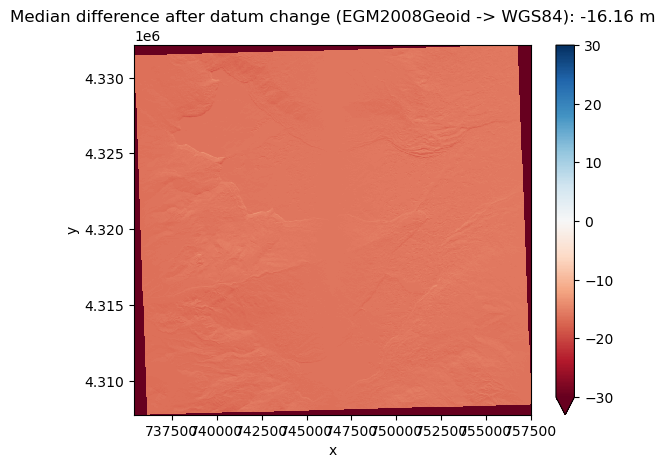

In [64]:
diff = output_copdem_reprojected - input_copdem_egm2008.rio.reproject_match(output_copdem_reprojected,resampling=rasterio.enums.Resampling.bilinear)
f,ax = plt.subplots()
diff.plot(vmin=-30, vmax=30, cmap="RdBu",ax=ax)
ax.set_title(f"Median difference after datum change (EGM2008Geoid -> WGS84): {diff.median().item():.2f} m")

##### Here again, we see that due to transformation of heights from EGM2008 Geoid to WGS84 ellipsoid, there is a median height change of ~ -16.6 m, which is close to the difference for the transformation from EGM96 Geoid to WGS84 ellipsoid.

### Example 3: 1 m 3DEP LiDAR DEM